In [1]:
from mpc import *


In [2]:
# Total simulation time 24h (1440m)
total_time = 1440  

# Sample time 1m
t_step = 1

# Number of control step total_time/t_step: 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


## Demonstration of the infeasibility of the MPC linear control strategy applied to the non-linear model

In [3]:
u1 = np.zeros(steps)
u2 = np.zeros(steps)

with open('./data/linear/results.json') as f:
    data = json.load(f)
    u1[:] = data['inputs']['aTc']
    u2[:] = data['inputs']['IPTG']

In [4]:
%%capture

setup_mpc = {
    'n_robust': 0,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': True,
}
model = template_model(False)
mpc = template_mpc(model, setup_mpc)
simulator = template_simulator(model, t_step)
estimator = do_mpc.estimator.StateFeedback(model)

simulator.reset_history()

mpc.x0 = x_0
simulator.x0 = x_0
estimator.x0 = x_0

mpc.set_initial_guess()

for k in range(steps):

    u = mpc.make_step(x_0)

    if (mpc.t0 - t_step) % 15 == 0:
        u = np.array([[u1[k]], [u2[k]]])
        ukm1 = u
    else:
        u = ukm1

    y_next = simulator.make_step(u)
    x_0 = estimator.make_step(y_next)
        
data = save_results(mpc, avg_period, t_step)


In [5]:
data['inputs']['aTc'] = [x for x in u1]
data['inputs']['IPTG'] = [x for x in u2]

------------------------------ PERFORMANCES METRICS ------------------------------
ISE: 2.94e+03
ITAE: 1.65e+06
------------------------------ PLOT RESULTS ------------------------------


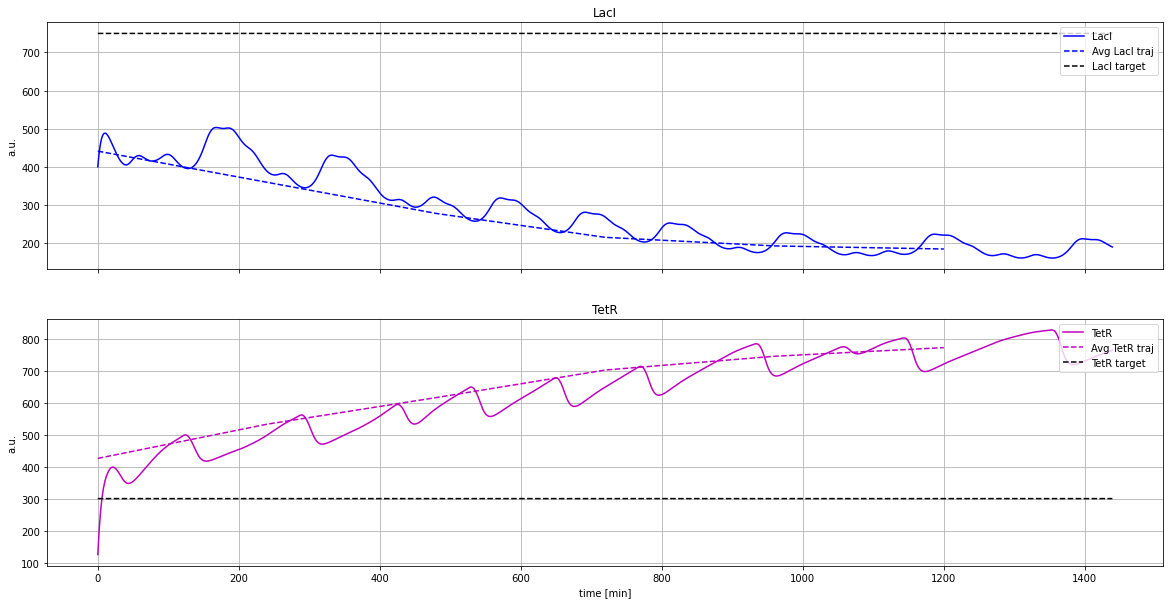

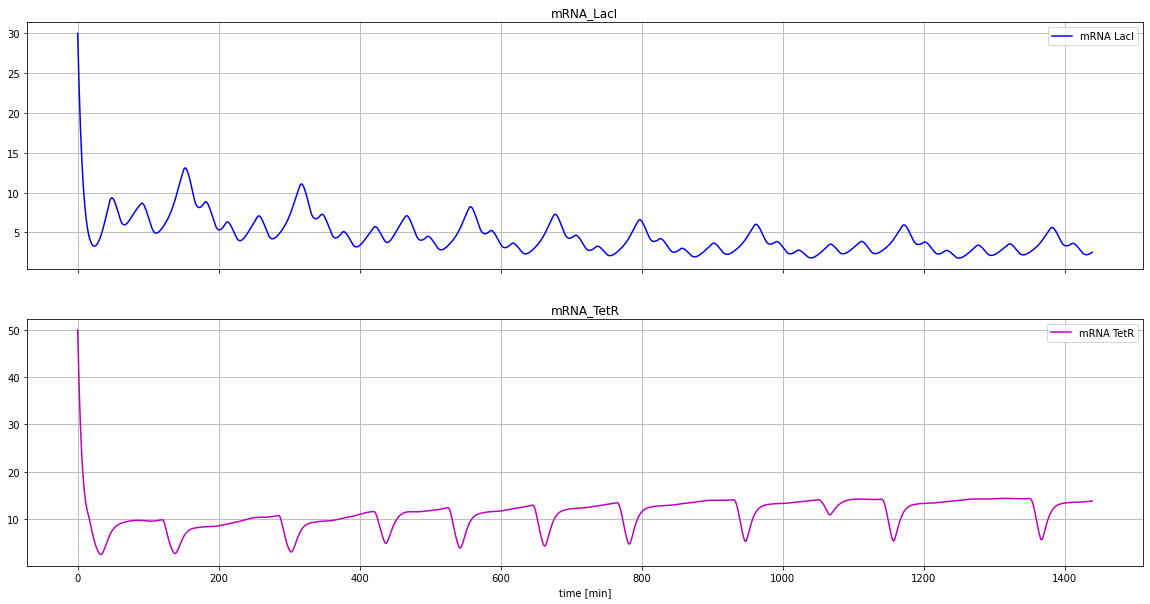

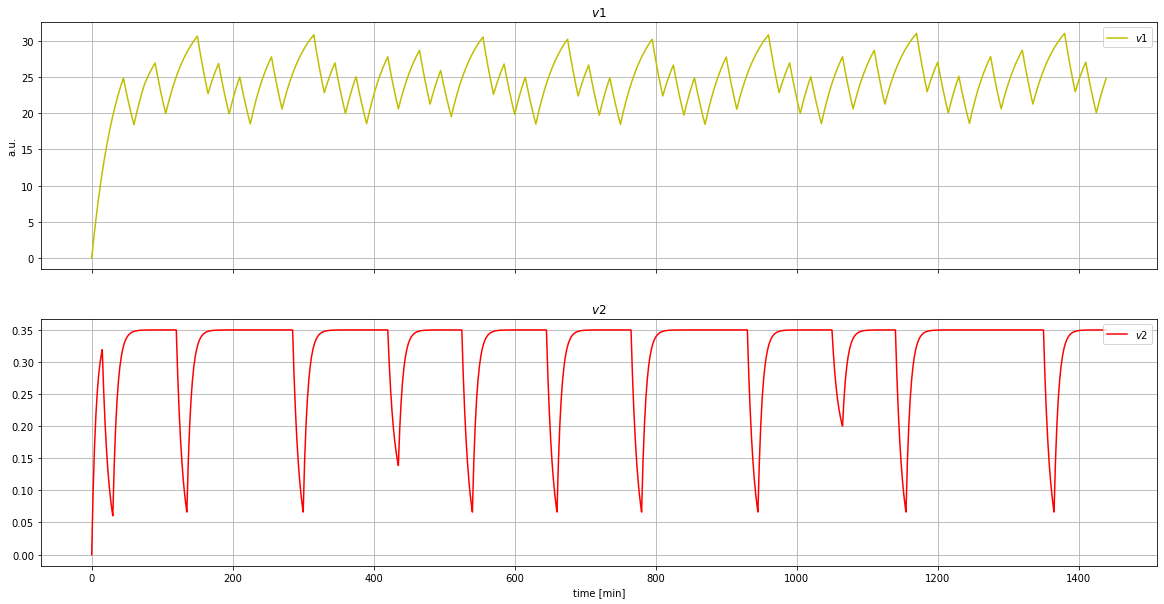

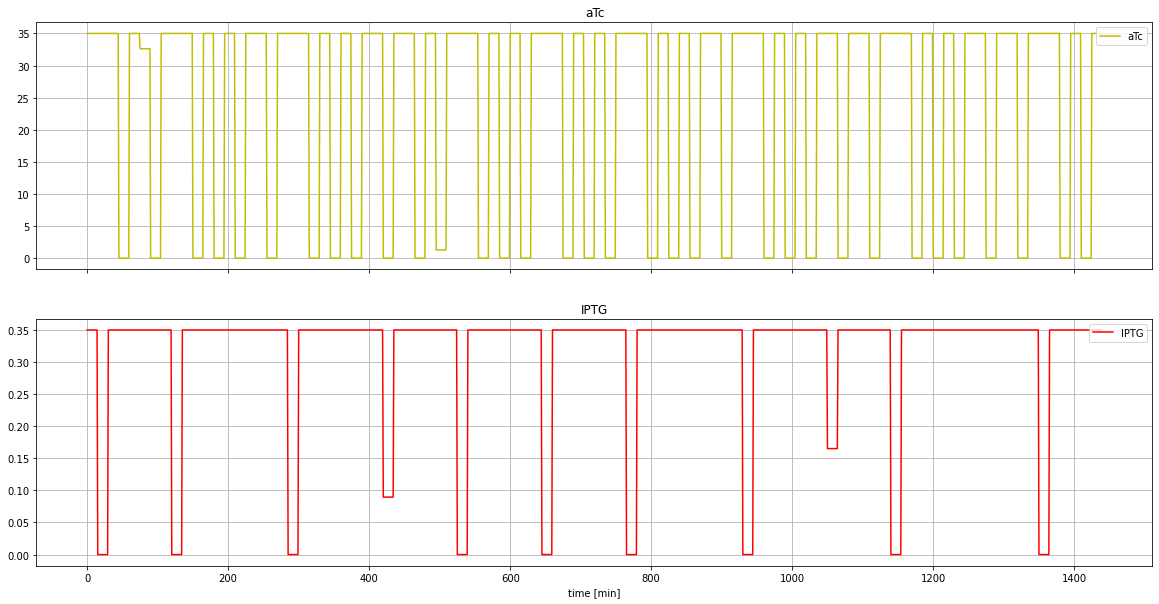

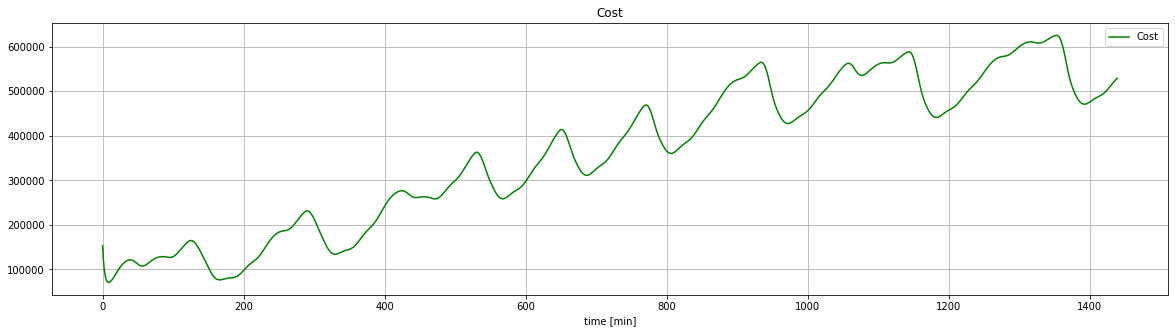

In [7]:
print('------------------------------ PERFORMANCES METRICS ------------------------------')
ISE, ITAE = compute_performance_metrics(data, total_time, t_step, avg_period, LacI_ref, TetR_ref)
print('ISE:', format(ISE, '.2e'))
print('ITAE:', format(ITAE, '.2e'))

print('------------------------------ PLOT RESULTS ------------------------------')
figures, lines = plot_results(data, total_time, avg_period, LacI_ref, TetR_ref)


In [8]:
export_results(data, 'infeasible', 'results', 'w')

In [9]:
animate_results('infeasible', 'proteins', update_protein, figures[0], (data, lines[0:6], np.arange(0, total_time, avg_period)), steps)
animate_results('infeasible', 'mRNAs', update_mRNA, figures[1], (data, lines[6:8]), steps)
animate_results('infeasible', 'internal_inducers', update_internal_inducers, figures[2], (data, lines[8:10]), steps)
animate_results('infeasible', 'external_inducers', update_external_inducers, figures[3], (data, lines[10:12]), steps)
animate_results('infeasible', 'cost', update_cost, figures[4], (data, lines[12:13]), steps)